In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 34.9 MB/s 
     |████████████████████████████████| 895 kB 41.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from distutils.version import LooseVersion as LV
from sklearn.model_selection import train_test_split
import io

#path = r'D:\tirocinioLC\tirocinioLC'
from google.colab import drive
drive.mount('/content/drive')
directory = '/content/drive/My Drive/Text Analytics/Data/'

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.10.0+cu111 Device: cuda [Tesla K80]


Import dataset

In [ ]:
df = pd.read_json(directory+'cleandf3.json')

df.Data = pd.to_datetime(df.Data)
df = df[df.Data.dt.year < 2019]
df = df.sample(frac=0.85, random_state=42)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32039 entries, 2840 to 29371
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  32039 non-null  int64         
 1   Titolo_Rif          32037 non-null  object        
 2   Rating              32039 non-null  object        
 3   Nome_Autore         32039 non-null  object        
 4   Data                32039 non-null  datetime64[ns]
 5   Numero_Capitoli     32039 non-null  int64         
 6   Racconto_Text_Only  32039 non-null  object        
 7   N_Tot_Rec           32039 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 2.2+ MB
None


,ID,Titolo_Rif,Rating,Nome_Autore,Data,Numero_Capitoli,Racconto_Text_Only,N_Tot_Rec
2840,59819,Tutto Per Una Meravigliosa Partita di Quidditch,verde,Gillywater,2005-11-19,1,Buon Compleanno Love! ...,12
33471,1135350,Dopotutto Babbanologia non è inutile...,verde,Gils_Malfoy,2012-06-29,1,AVVERTENZE! Prima di iniziare a leggere è bene...,7
34947,1260606,Non piangere.,verde,A n o n y m o u s Rei,2012-11-09,1,"Ti tappi un altro po’ le orecchie, Theo. Fa...",2
35908,1407567,Una finestra sul passato,verde,Ma_AiLing,2012-11-24,1,Il professor Lupin si stava dirigendo nel suo ...,2
22312,690486,Qualcuno uccida Potter,verde,lotti_,2011-06-04,1,"Un raggio di sole scarlatto, tenue e delicata ...",4


In [ ]:
col         = 'N_Tot_Rec'
conditions  = [ (df[col] <= 2) , (df[col] >= 6)]
choices     = [ 'unpopular', 'popular' ] 
    
df[col] = np.select(conditions, choices, default=np.nan)

df = df[(df['N_Tot_Rec']=='unpopular') | (df['N_Tot_Rec']=='popular')]

df.head()

,ID,Titolo_Rif,Rating,Nome_Autore,Data,Numero_Capitoli,Racconto_Text_Only,N_Tot_Rec
2840,59819,Tutto Per Una Meravigliosa Partita di Quidditch,verde,Gillywater,2005-11-19,1,Buon Compleanno Love! ...,popular
33471,1135350,Dopotutto Babbanologia non è inutile...,verde,Gils_Malfoy,2012-06-29,1,AVVERTENZE! Prima di iniziare a leggere è bene...,popular
34947,1260606,Non piangere.,verde,A n o n y m o u s Rei,2012-11-09,1,"Ti tappi un altro po’ le orecchie, Theo. Fa...",unpopular
35908,1407567,Una finestra sul passato,verde,Ma_AiLing,2012-11-24,1,Il professor Lupin si stava dirigendo nel suo ...,unpopular
28797,889632,Stories,verde,Viki_chan,2011-10-12,1,Tante delle mie Auror preferite hanno usato - ...,popular


In [ ]:
target = df[[col]]
del df[col]

In [ ]:
from sklearn.model_selection import train_test_split, RepeatedKFold

#split on train-test 
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.30, random_state=42, stratify=target, shuffle=True) 
print(f"Train set size: {len(x_train)}\nTest set size: {len(x_test)}")

Train set size: 15080
Test set size: 6464


Text Preparation

In [ ]:
sentences_train = ["[CLS] " + s for s in x_train.Racconto_Text_Only]
sentences_test = ["[CLS] " + s for s in x_test.Racconto_Text_Only]
labels_train = [1 if (value=='popular') else 0 for value in y_train.N_Tot_Rec]
labels_test  = [1 if (value=='popular') else 0 for value in y_test.N_Tot_Rec]

In [ ]:
from transformers import AutoModel, AutoTokenizer

model_name = "dbmdz/bert-base-italian-xxl-cased"

tokenizer = BertTokenizer.from_pretrained(model_name)

model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from tqdm import tqdm

#tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
#tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

In [ ]:
import pickle
#with open(directory+r'SUCCESStokenized_train.pkl','wb') as outfile:
#    pickle.dump(tokenized_train, outfile)

#with open(directory+r'SUCCESStokenized_test.pkl','wb') as outfile:
#  pickle.dump(tokenized_test, outfile)

In [ ]:
a_file = open(directory+r"SUCCESStokenized_train.pkl", "rb")
tokenized_train = pickle.load(a_file)
#b_file = open(directory+r"SUCCESStokenized_test.pkl", "rb")
#tokenized_test = pickle.load(b_file)

In [ ]:
#len(tokenized_test)

In [ ]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 128

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
#tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

'''MAX_LEN_train = 125
K = MAX_LEN_train

tokenized_train = [t[((len(t) // 2) - (K // 2)) : ((len(t) // 2) + (K // 2) + 1) ]+['SEP'] for t in tokenized_train]
tokenized_train = [["[CLS]"] + s for s in tokenized_train]

print ("The truncated tokenized first train sentence:")
print (tokenized_train[0])'''

The truncated tokenized first training sentence:
['[CLS]', 'Ringrazio', 'anche', 'solo', 'chi', 'legge', '.', 'Partecipa', 'alla', 'fan', '##fic', '##tion', 'cha', '##llen', '##ge', ':', 'Persona', '##ggi', ':', 'Luna', '/', 'Bla', '##ise', '(', '?', ')', 'Pro', '##mp', '##t', ':', 'po', '##zione', 'poli', '##su', '##cco', 'La', 'falsa', 'Luna', 'Bla', '##ise', 'si', 'affa', '##cci', '##ò', 'dalla', 'finestra', 'e', 'asso', '##tti', '##gli', '##ò', 'gli', 'occhi', '.', 'Senti', '##va', 'gli', 'occhi', 'bruciare', ',', 'strin', '##se', 'le', 'labbra', 'pronuncia', '##te', 'fino', 'a', 'farle', 'sb', '##ian', '##care', '.', 'Guard', '##ò', 'la', 'figura', 'di', 'Luna', 'sal', '##tella', '##re', 'intorno', 'a', 'quella', 'di', 'Dra', '##co', 'e', 'avver', '##tì', 'una', 'fitta', 'al', 'petto', '.', 'Sen', '##tì', 'il', 'battito', 'cardiaco', 'diminuire', ',', 'abbass', '##ò', 'il', 'capo', 'e', 'fiss', '##ò', 'i', 'capelli', 'bion', '##do', '-', 'platino', 'di', 'Mal', '##fo', '##y', '.',

'MAX_LEN_train = 125\nK = MAX_LEN_train\n\ntokenized_train = [t[((len(t) // 2) - (K // 2)) : ((len(t) // 2) + (K // 2) + 1) ]+[\'SEP\'] for t in tokenized_train]\ntokenized_train = [["[CLS]"] + s for s in tokenized_train]\n\nprint ("The truncated tokenized first train sentence:")\nprint (tokenized_train[0])'

In [ ]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, 128-len(i)),
                             mode='constant') for i in ids_train])

#ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
#ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
#                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[  102 28603   409   484   524  2572   697 28679   334  4895   890  1230
 13272  9397   556  1587 26798   365  1587 11456  1927  4720  3699   249
  3098  4567   701   205 30881  1587   228   167   644  3452   531   309
 13533 11456  4720  3699   223  4904   960 30940   511  6785   126 12278
   238   183 30940   368  2969   697  2869   187   368  2969 19779  1307
 10073   271   199 15816  6744   124   967   111 10191  3891   688  2650
   697 17137 30940   146  5069   120 11456   836  3763   113  3899   111
   899   120  6345   172   126  7620 12341   224 30116   157 11399   697
  6796 12341   162 21602 18294 17068  1307 28953 30940   162  2133   126
 30506 30940   134  4896 10448   165   179 26713   120  3877   877 30931
   697   179  1529 23442   894   111   290   101]


In [ ]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

#for seq in ids_test:
#  seq_mask = [float(i>0) for i in seq]
#  amasks_test.append(seq_mask)

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
#test_inputs = torch.tensor(ids_test)
#test_labels = torch.tensor(labels_test)
#test_masks  = torch.tensor(amasks_test)

In [ ]:
#print('inout', len(test_inputs))
#print('masks', len(test_masks))
#print('labels', len(test_labels))

In [ ]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
#test_data = TensorDataset(test_inputs, test_masks, test_labels)
#test_sampler = SequentialSampler(test_data)
#test_dataloader = DataLoader(test_data, sampler=test_sampler,
 #                            batch_size=BATCH_SIZE)
#print(len(test_data), 'documents')

Datasets:
Train: 13572 documents
Validation: 1508 documents
Test: 

Bert model initialization

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
print('Pretrained BERT model "{}" loaded'.format(model_name))

Pretrained BERT model "dbmdz/bert-base-italian-xxl-cased" loaded


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# MODIFICHE

In [ ]:
EPOCHS = 3 
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import torch.nn as nn
from sklearn.metrics import f1_score

Use CrossEntropyLoss as training metric!

In [ ]:
loss_fn = nn.CrossEntropyLoss()
def f1_score_func(preds, labels):
    preds_copy = torch.tensor(preds)
    preds_flat = np.argmax(preds_copy.cpu(), axis=1).flatten()
    labels_flat = labels.cpu().flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

Modified training and evaluation functions, to compute and print also the VAL loss and the confusion matrix on the validation and test sets.

In [ ]:
from tabulate import tabulate
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()
  # Reset tracking variables at the beginning of each epoch

  total_loss, batch_loss, batch_counts, f1_value_train_batch, f1_value_train_tot  = 0, 0, 0, 0, 0
  
  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels) 
    ###########################################################################

    loss = loss_fn(outputs.logits, b_labels) 
    #batch_loss += loss.item()
    total_loss += loss.item()

    #f1_value_train_batch += f1_score_func(outputs[0], b_labels)
    f1_value_train_tot += f1_score_func(outputs.logits, b_labels) 

    if loss_vector is not None: 
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

  avg_train_loss = total_loss / len(train_dataloader)
  avg_f1_value = f1_value_train_tot / len(train_dataloader)
  print('\n avg_train_loss', avg_train_loss)
  print('avg_f1_value', avg_f1_value)

def evaluate(loader, loss_vector=None, test=False):
    model.eval()

    n_correct, n_all = 0, 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    b_labels_v2 = torch.tensor([],dtype=torch.long)
    b_input_ids_v2 = torch.tensor([], dtype=torch.long)
    b_attn_mask_v2 = torch.tensor([], dtype=torch.long)

    batchcount = 0
    for batch in loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        b_labels_v2 = torch.cat((b_labels_v2.to(device), b_labels), 0)
        b_input_ids_v2 = torch.cat((b_input_ids_v2.to(device), b_input_ids), 0)
        b_attn_mask_v2 = torch.cat((b_attn_mask_v2.to(device), b_input_mask), 0)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                          attention_mask=b_input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu()#.numpy()

        #Predictions
        predictions = np.argmax(logits.numpy(), axis=1)
        #Labels
        labels = b_labels.to('cpu').numpy()

        n_correct += np.sum(predictions == labels)
        n_all += len(labels)

        for truth, pred in zip(labels, predictions):
          if truth == 0 and pred == 0:
            TN +=1
          elif truth == 1 and pred == 1:
            TP +=1
          elif truth == 1 and pred == 0:
            FN +=1
          elif truth ==0 and pred == 1:
            FP +=1

        if test:
          batchcount += 1
          print("Ho preso", batchcount, 'batches su ?')

    with torch.no_grad():
        logits_v2 = model(b_input_ids_v2, b_attn_mask_v2)

    if test:
      print('Ho fatto le logits')

    del b_input_ids_v2
    del b_attn_mask_v2
    torch.cuda.empty_cache()

    if test:
      print('Ho svuotato la cache')

    b_labels_v2 = b_labels_v2.to(device)

    if test:
      print('Ho spostato le labels sul device')

    loss = loss_fn(logits_v2.logits, b_labels_v2)

    if test:
      print('Ho calcolato la val loss')
    val_loss = loss.item()

    print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
    print('VAL LOSS', val_loss)

    if (TP+FP!=0):
      precision_1 = (TP) / (TP+FP)
    else:
      precision_1 = 0

    if (TP+FN!=0):
      recall_1 = (TP) / (TP+FN)
    else:
      recall_1 = 0

    precision_0 = TN / (TN+FN)
    recall_0 = TN / (TN+FP)

    f1_0 = 2* ((precision_0*recall_0) / (precision_0+recall_0))
    if (precision_1+recall_1) != 0:
      f1_1 = 2* ((precision_1*recall_1) / (precision_1+recall_1))
    else:
      f1_1 = 0

    data = [['unpopular', precision_0, recall_0, f1_0],
            ['popular', precision_1, recall_1, f1_1]]

    data2 = [['predPOP', TP, FP], 
             ['predNONPOP', FN, TN]]

    print(tabulate(data, headers=["Class", "Precision", "Recall", "F1"]))
    print()
    print(tabulate(data2, headers=['', 'truthPOP', 'truthNONPOP']))

    if loss_vector is not None: 
      loss_vector.append(val_loss)


In [ ]:
import warnings
warnings.filterwarnings("ignore")
train_lossv = []
val_lossv = []
print("Start training...\n")
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader, val_lossv)

Start training...


Train Epoch: 1 [0/13572 (0%)]	Loss: 0.695733
Train Epoch: 1 [6400/13572 (47%)]	Loss: 0.613466
Train Epoch: 1 [12800/13572 (94%)]	Loss: 0.764010

 avg_train_loss 0.6545032173745773
avg_f1_value 0.5861266393804022

Validation set:
Accuracy: [960/1508] 0.6366
VAL LOSS 0.6275979280471802
Class        Precision    Recall        F1
---------  -----------  --------  --------
unpopular     0.675237  0.61834   0.645537
popular       0.59948   0.657632  0.627211

              truthPOP    truthNONPOP
----------  ----------  -------------
predPOP            461            308
predNONPOP         240            499

Train Epoch: 2 [0/13572 (0%)]	Loss: 0.582633
Train Epoch: 2 [6400/13572 (47%)]	Loss: 0.519941
Train Epoch: 2 [12800/13572 (94%)]	Loss: 0.498008

 avg_train_loss 0.5757601529009202
avg_f1_value 0.6989769525512527

Validation set:
Accuracy: [997/1508] 0.6611
VAL LOSS 0.626848042011261
Class        Precision    Recall        F1
---------  -----------  --------  --------

In [ ]:
val_lossv

[0.6275979280471802, 0.626848042011261, 0.7040935754776001]

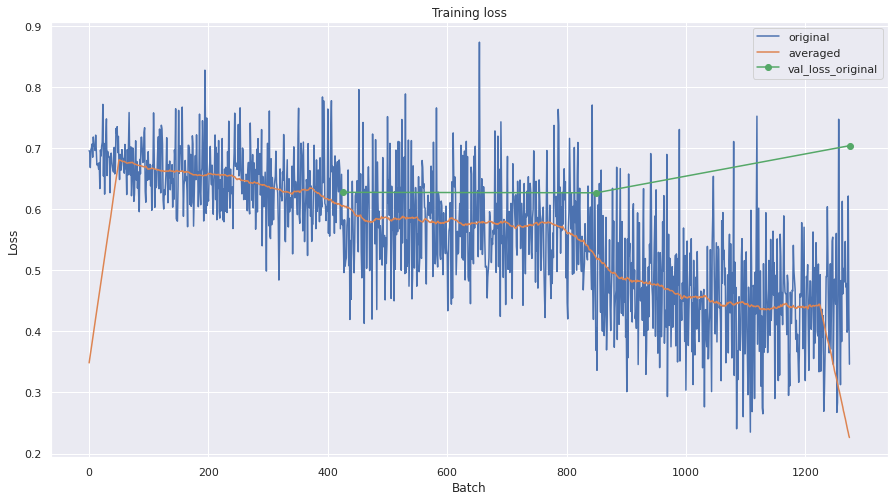

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
val_ticks = np.arange(len(train_lossv)/len(val_lossv), len(train_lossv)+len(train_lossv)/len(val_lossv), len(train_lossv)/len(val_lossv))
plt.plot(val_ticks, val_lossv, label='val_loss_original', marker='o')
plt.legend(loc='best')
plt.show()

In [ ]:
with open(directory+r'MODEL_SUCCESS3epochsFIRSTTOKENS.pkl','wb') as outfile:
    pickle.dump(model, outfile)

Evaluation: in another notebook!